In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage
from sklearn.datasets import fetch_olivetti_faces

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\JH\scikit_learn_data


(-0.5, 1279.5, 1279.5, -0.5)

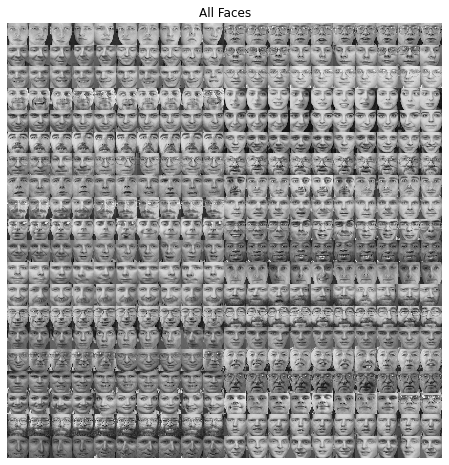

In [3]:
faces=fetch_olivetti_faces() # 올리베티 얼굴 데이터셋 패키지 불러오기

#이미지 흑백으로 만들고 LIME이 처리할 수 있는 형태로 변환하기
X_vec=np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1,64,64))],0) 
#faces.data의 이미지 한장에 대해(iimg) 이미지를 (64,64)크기로 재조정한다.
#이떄 reshape함수는 -1파라미터를 쓰는데 -1은 다음 파라미터를 (64x64) 크기에 맞춰 원본이미지를 조정한다는 의미다.
#reshape(-1,size)는 for loop 를 사용하는 reshape()에 이용하는 기법
#이후 이미지를 gray2rgb메서드에 입력한다. 흑백이미지를 RGB 3채널로 확장해준다.
#이렇게 전처리가 끝난 올리베티 얼굴 데이터셋 모양은 (400,64,64,3)으로 (이미지개수,가로,세로,컬러채널) 이다.
y_vec=faces.target.astype(np.uint8)
#y_vec은 이미지에 대응되는 사람 레이블을 저장한다. 정수형으로 저장한다.
%matplotlib inline

fig,ax1=plt.subplots(1,1,figsize=(8,8))
ax1.imshow(montage(X_vec[:,:,:,0]),
          cmap='gray',interpolation='none')
ax1.set_title('All Faces')
ax1.axis('off')

In [4]:
y_vec

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

(-0.5, 63.5, 63.5, -0.5)

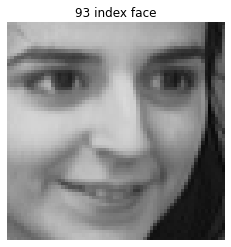

In [5]:
index=93
plt.imshow(X_vec[index],cmap='gray')
plt.title('{} index face'.format(index))
plt.axis('off')

In [6]:
def predict_proba(image):
    return session.run(model_predict,feed_dict={preprocessed_image:image})

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_vec,y_vec,train_size=0.70)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    def __init__(self,step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)
    
makegray_step=PipeStep(lambda img_list:[rgb2gray(img) for img in img_list])
flatten_step=PipeStep(lambda img_list:[img.ravel() for img in img_list])

simple_pipeline=Pipeline([
    ('Make Gray',makegray_step),
    ('Flatten Image',flatten_step),
    ('Normalize',Normalizer()),
    ('MLP',MLPClassifier(
    activation='relu',
    alpha=1e-7,
    epsilon=1e-6,
    hidden_layer_sizes=(800,120),
    random_state=1))
])

In [19]:
simple_pipeline.fit(X_train,y_train)

C:\Users\JH\.conda\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x0000026CBFA4D550>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x0000026CBFA4D518>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=1))])

In [20]:
pipe_pred_test=simple_pipeline.predict(X_test)
pipe_pred_prop=simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test,y_pred=pipe_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         4
           3       1.00      0.33      0.50         3
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         3
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         4
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       0.00      0.00      0.00         0
          12       0.38      0.60      0.46         5
          13       0.86      0.86      0.86         7
          14       1.00      1.00      1.00         3
          15       0.33      0.33      0.33         3
          16       0.67      1.00      0.80         2
          17       1.00    

C:\Users\JH\.conda\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JH\.conda\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer=lime_image.LimeImageExplainer()
segmenter=SegmentationAlgorithm('slic',
                               n_segments=100,
                               compactness=1,
                               sigma=1)

In [56]:
%%time
olivetti_test_index=0
exp=explainer.explain_instance(X_test[olivetti_test_index],
                              classifier_fn=simple_pipeline.predict_proba,
                              top_labels=6,
                              num_samples=1000,
                              segmentation_fn=segmenter)

C:\Users\JH\.conda\envs\py36\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


Wall time: 596 ms


Text(0.5, 1.0, 'Show mask only')

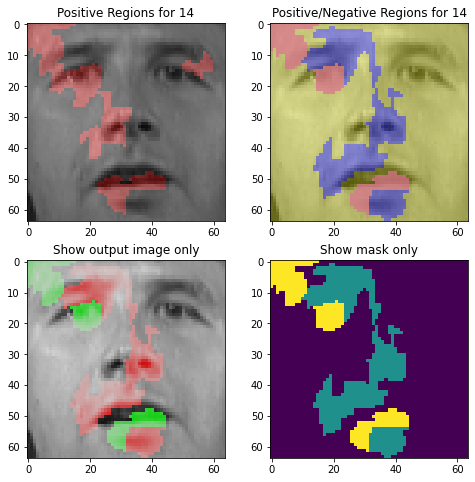

In [57]:
from skimage.color import label2rgb

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(8,8))

temp,mask=exp.get_image_and_mask(y_test[olivetti_test_index],
                                positive_only=True,
                                num_features=8,
                                hide_rest=False)
ax1.imshow(label2rgb(mask,temp,bg_label=0),
          interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))

temp,mask=exp.get_image_and_mask(y_test[olivetti_test_index],
                                positive_only=False,
                                num_features=8,
                                hide_rest=False)
ax2.imshow(label2rgb(4-mask,temp,bg_label=0),
          interpolation='nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))

ax3.imshow(temp,interpolation='nearest')
ax3.set_title('Show output image only')

ax4.imshow(mask,interpolation='nearest')
ax4.set_title('Show mask only')

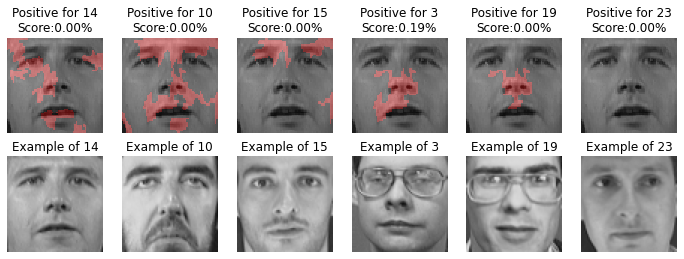

In [61]:
olivetti_test_index=1

fig,m_axs=plt.subplots(2,6,figsize=(12,4))
for i,(c_ax,gt_ax) in zip(exp.top_labels, m_axs.T):
    temp,mask=exp.get_image_and_mask(i,
                                    positive_only=True,
                                    num_features=12,
                                    hide_rest=False,
                                    min_weight=0.001)

    c_ax.imshow(label2rgb(mask,temp,bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*pipe_pred_prop[olivetti_test_index,i]))
    c_ax.axis('off')

    face_id=np.random.choice(np.where(y_train==i)[0])

    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')